<a href="https://colab.research.google.com/github/abdelkadergelany/Intrusion-Detection-in-IoT-Based-Network/blob/main/Saving%20To%20Continue%20after%20sport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## References 

 * Data source: https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/
 * Sample/starter code: https://github.com/Nir-J/ML-Projects/blob/master/UNSW-Network_Packet_Classification/unsw.py

In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize,StandardScaler

import xgboost, lightgbm
from mlxtend.classifier import EnsembleVoteClassifier

# Preprocessing (transformation/scaling) 

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [3]:
# Contaminsation mean pollution (outliers) in data
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(1 - len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test  contamination ", round(1 - len(tmp)/len(test),2),'\n')

if contamination > 0.5:
    print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
    contamination = round(1-contamination,2)
    print(f'contamination is now {contamination}')

train contamination  0.68
test  contamination  0.55 

contamination is 0.68, which is greater than 0.5. Fixing...
contamination is now 0.32


In [5]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode(), "Which is,", le1.inverse_transform(vector.mode()))
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")

attack cat: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int64 Which is, [6]
mode 0.3609225646458884 %


In [6]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9])
combined_data.head(3)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,6,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,6,0


In [8]:
data_x = combined_data.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data.loc[:,['label']]
# del combined_data # free mem
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.20, random_state=42) # TODO

In [9]:
X_test.head(3)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
122637,0.000005,119,2,5,2,0,114,0,200000.005100,254,0,9.120000e+07,0.000000,0,0,0.0050,0.000,0.00000,0.0,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,13,2,9,9,9,13,0,0,0,9,13,0
137118,0.000003,119,2,5,2,0,114,0,333333.321500,254,0,1.520000e+08,0.000000,0,0,0.0030,0.000,0.00000,0.0,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,16,2,16,16,16,16,0,0,0,17,16,0
69948,1.167584,113,0,2,6,2,1012,86,5.995286,62,252,5.782882e+03,294.625488,2,1,233.5168,0.001,13675.72975,0.0,255,1497222707,3407537974,255,0.940009,0.560296,0.379713,169,43,0,0,2,3,1,1,1,2,0,0,0,2,2,0


In [7]:
# X_train.shape
# y_train.shape
# X_test.shape # test is larger... good 
# y_test.shape

(206138, 42)

(206138, 1)

(51535, 42)

(51535, 1)

# Benchmark

In [9]:
# DTC = DecisionTreeClassifier()
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators= 500) # multiclass

list_of_CLFs_names = []
list_of_CLFs = [ RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

Acc: 0.95240 for the RandomForestClassifier
Acc: 0.95133 for the ExtraTreesClassifier
Acc: 0.93653 for the XGBClassifier
Acc: 0.95269 for the LGBMClassifier


<h1>Testing</h1>

In [46]:
X_test.head(3)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
122637,0.000005,119,2,5,2,0,114,0,200000.005100,254,0,9.120000e+07,0.000000,0,0,0.0050,0.000,0.00000,0.0,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,13,2,9,9,9,13,0,0,0,9,13,0
137118,0.000003,119,2,5,2,0,114,0,333333.321500,254,0,1.520000e+08,0.000000,0,0,0.0030,0.000,0.00000,0.0,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,16,2,16,16,16,16,0,0,0,17,16,0
69948,1.167584,113,0,2,6,2,1012,86,5.995286,62,252,5.782882e+03,294.625488,2,1,233.5168,0.001,13675.72975,0.0,255,1497222707,3407537974,255,0.940009,0.560296,0.379713,169,43,0,0,2,3,1,1,1,2,0,0,0,2,2,0


In [10]:
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
RFC.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [11]:
X_test.head(3)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
122637,0.000005,119,2,5,2,0,114,0,200000.005100,254,0,9.120000e+07,0.000000,0,0,0.0050,0.000,0.00000,0.0,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,13,2,9,9,9,13,0,0,0,9,13,0
137118,0.000003,119,2,5,2,0,114,0,333333.321500,254,0,1.520000e+08,0.000000,0,0,0.0030,0.000,0.00000,0.0,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,16,2,16,16,16,16,0,0,0,17,16,0
69948,1.167584,113,0,2,6,2,1012,86,5.995286,62,252,5.782882e+03,294.625488,2,1,233.5168,0.001,13675.72975,0.0,255,1497222707,3407537974,255,0.940009,0.560296,0.379713,169,43,0,0,2,3,1,1,1,2,0,0,0,2,2,0


In [12]:
#X_testC['scores']= RFC.decision_function(X_test)
New_X_test = X_test
New_X_test['sign_deciscion']= RFC.predict(New_X_test)
New_X_test.head(5)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,sign_deciscion
122637,0.000005,119,2,5,2,0,114,0,200000.005100,254,0,9.120000e+07,0.000000,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,13,2,9,9,9,13,0,0,0,9,13,0,1
137118,0.000003,119,2,5,2,0,114,0,333333.321500,254,0,1.520000e+08,0.000000,0,0,0.003000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,16,2,16,16,16,16,0,0,0,17,16,0,1
69948,1.167584,113,0,2,6,2,1012,86,5.995286,62,252,5.782882e+03,294.625488,2,1,233.516800,0.001000,13675.729750,0.000000,255,1497222707,3407537974,255,0.940009,0.560296,0.379713,169,43,0,0,2,3,1,1,1,2,0,0,0,2,2,0,0
45921,0.486485,113,5,4,10,8,798,1568,34.944551,62,252,1.182359e+04,22561.845700,2,2,54.053889,59.958430,2705.531092,82.549047,255,101844950,785426226,255,0.138611,0.065983,0.072628,80,196,1,372,1,1,1,1,1,1,0,0,1,1,1,0,1
31408,0.072147,119,0,2,4,4,568,312,97.024136,31,29,4.723689e+04,25947.025390,0,0,18.674334,23.547666,26.397475,33.299309,0,0,0,0,0.000000,0.000000,0.000000,142,78,0,0,7,0,5,1,1,5,0,0,0,2,8,0,0


In [13]:
 deciscion = pd.DataFrame(New_X_test['sign_deciscion'])
deciscion

,sign_deciscion
122637,1
137118,1
69948,0
45921,1
31408,0
...,...
10687,1
120658,1
61193,1
35810,0


In [14]:
#X_test = X_test.drop(['anom_deciscion'], axis=1)
X_test = X_test.drop(['sign_deciscion'], axis=1)
X_test.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
122637,0.000005,119,2,5,2,0,114,0,200000.005100,254,0,9.120000e+07,0.000000,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,13,2,9,9,9,13,0,0,0,9,13,0
137118,0.000003,119,2,5,2,0,114,0,333333.321500,254,0,1.520000e+08,0.000000,0,0,0.003000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,16,2,16,16,16,16,0,0,0,17,16,0
69948,1.167584,113,0,2,6,2,1012,86,5.995286,62,252,5.782882e+03,294.625488,2,1,233.516800,0.001000,13675.729750,0.000000,255,1497222707,3407537974,255,0.940009,0.560296,0.379713,169,43,0,0,2,3,1,1,1,2,0,0,0,2,2,0
45921,0.486485,113,5,4,10,8,798,1568,34.944551,62,252,1.182359e+04,22561.845700,2,2,54.053889,59.958430,2705.531092,82.549047,255,101844950,785426226,255,0.138611,0.065983,0.072628,80,196,1,372,1,1,1,1,1,1,0,0,1,1,1,0
31408,0.072147,119,0,2,4,4,568,312,97.024136,31,29,4.723689e+04,25947.025390,0,0,18.674334,23.547666,26.397475,33.299309,0,0,0,0,0.000000,0.000000,0.000000,142,78,0,0,7,0,5,1,1,5,0,0,0,2,8,0


<h1>end Testing</h1>

In [50]:
X_test.shape

(51535, 43)

In [55]:
eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
_ = eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))

# pred = eclf.predict(X_test)
# probas = eclf.predict_proba(X_test)

Acc: 0.95353 for the EnsembleVoteClassifier


## Unsupervied ML

In [15]:
%%capture 
!pip install pyod
!pip install hdbscan
!pip install combo
!pip install SOM...... # https://github.com/AICoE/log-anomaly-detector/blob/master/Notebooks/SOM_retrain_notebook/SOM_UserFeedbackPOC.ipynb
!pip install somtf

In [16]:
!pip install rrcf

  Created wheel for rrcf: filename=rrcf-0.4.3-cp36-none-any.whl size=9811 sha256=bc8ef627022714291ecd9e457ddcbab00df94ecd395a7427c9ccd9a990d2b4f5
  Stored in directory: /root/.cache/pip/wheels/6c/7c/b7/8983591821eb2c00a31795b29232dcedc4d7fad70a6c663870
Successfully built rrcf


In [17]:
import gc, os, pickle
from datetime import datetime

import numpy as np
import pandas as pd
from collections import Counter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pyod
from hdbscan import HDBSCAN
import rrcf

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import * 
from sklearn.preprocessing import *
from sklearn.svm import *
from sklearn.metrics import  precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report


In [18]:
from pyod.models import lof, cblof, cof, pca, iforest, knn, mcd, ocsvm, sod, abod, hbos #, auto_encoder, vae
contamination = 0.4
threshold = 0.75

<table class="docutils align-default">
<colgroup>
<col style="width: 8%">
<col style="width: 6%">
<col style="width: 41%">
<col style="width: 2%">
<col style="width: 21%">
<col style="width: 22%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Type</p></th>
<th class="head"><p>Abbr</p></th>
<th class="head"><p>Algorithm</p></th>
<th class="head"><p>Year</p></th>
<th class="head"><p>Class</p></th>
<th class="head"><p>Ref</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>Linear Model</p></td>
<td><p>PCA</p></td>
<td><p>Principal Component Analysis (the sum of weighted projected distances to the eigenvector hyperplanes)</p></td>
<td><p>2003</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.pca.PCA" title="pyod.models.pca.PCA"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.pca.PCA</span></code></a></p></td>
<td><p><span id="id3">[<a class="reference internal" href="#id53"><span>ASCSC03</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Linear Model</p></td>
<td><p>MCD</p></td>
<td><p>Minimum Covariance Determinant (use the mahalanobis distances as the outlier scores)</p></td>
<td><p>1999</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.mcd.MCD" title="pyod.models.mcd.MCD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.mcd.MCD</span></code></a></p></td>
<td><p><span id="id4">[<a class="reference internal" href="#id57"><span>ARD99</span></a>,<a class="reference internal" href="#id58"><span>AHR04</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Linear Model</p></td>
<td><p>OCSVM</p></td>
<td><p>One-Class Support Vector Machines</p></td>
<td><p>2001</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.ocsvm.OCSVM" title="pyod.models.ocsvm.OCSVM"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.ocsvm.OCSVM</span></code></a></p></td>
<td><p><span id="id5">[<a class="reference internal" href="#id68"><span>AScholkopfPST+01</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Linear Model</p></td>
<td><p>LMDD</p></td>
<td><p>Deviation-based Outlier Detection (LMDD)</p></td>
<td><p>1996</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.lmdd.LMDD" title="pyod.models.lmdd.LMDD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.lmdd.LMDD</span></code></a></p></td>
<td><p><span id="id6">[<a class="reference internal" href="#id75"><span>AAAR96</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Proximity-Based</p></td>
<td><p>LOF</p></td>
<td><p>Local Outlier Factor</p></td>
<td><p>2000</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.lof.LOF" title="pyod.models.lof.LOF"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.lof.LOF</span></code></a></p></td>
<td><p><span id="id7">[<a class="reference internal" href="#id55"><span>ABKNS00</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Proximity-Based</p></td>
<td><p>COF</p></td>
<td><p>Connectivity-Based Outlier Factor</p></td>
<td><p>2002</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.cof.COF" title="pyod.models.cof.COF"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.cof.COF</span></code></a></p></td>
<td><p><span id="id8">[<a class="reference internal" href="#id69"><span>ATCFC02</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Proximity-Based</p></td>
<td><p>CBLOF</p></td>
<td><p>Clustering-Based Local Outlier Factor</p></td>
<td><p>2003</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.cblof.CBLOF" title="pyod.models.cblof.CBLOF"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.cblof.CBLOF</span></code></a></p></td>
<td><p><span id="id9">[<a class="reference internal" href="#id59"><span>AHXD03</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Proximity-Based</p></td>
<td><p>LOCI</p></td>
<td><p>LOCI: Fast outlier detection using the local correlation integral</p></td>
<td><p>2003</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.loci.LOCI" title="pyod.models.loci.LOCI"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.loci.LOCI</span></code></a></p></td>
<td><p><span id="id10">[<a class="reference internal" href="#id62"><span>APKGF03</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Proximity-Based</p></td>
<td><p>HBOS</p></td>
<td><p>Histogram-based Outlier Score</p></td>
<td><p>2012</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.hbos.HBOS" title="pyod.models.hbos.HBOS"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.hbos.HBOS</span></code></a></p></td>
<td><p><span id="id11">[<a class="reference internal" href="#id52"><span>AGD12</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Proximity-Based</p></td>
<td><p>kNN</p></td>
<td><p>k Nearest Neighbors (use the distance to the kth nearest neighbor as the outlier score</p></td>
<td><p>2000</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.knn.KNN" title="pyod.models.knn.KNN"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.knn.KNN</span></code></a></p></td>
<td><p><span id="id12">[<a class="reference internal" href="#id48"><span>ARRS00</span></a>,<a class="reference internal" href="#id49"><span>AAP02</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Proximity-Based</p></td>
<td><p>AvgKNN</p></td>
<td><p>Average kNN (use the average distance to k nearest neighbors as the outlier score)</p></td>
<td><p>2002</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.knn.KNN" title="pyod.models.knn.KNN"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.knn.KNN</span></code></a></p></td>
<td><p><span id="id13">[<a class="reference internal" href="#id48"><span>ARRS00</span></a>,<a class="reference internal" href="#id49"><span>AAP02</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Proximity-Based</p></td>
<td><p>MedKNN</p></td>
<td><p>Median kNN (use the median distance to k nearest neighbors as the outlier score)</p></td>
<td><p>2002</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.knn.KNN" title="pyod.models.knn.KNN"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.knn.KNN</span></code></a></p></td>
<td><p><span id="id14">[<a class="reference internal" href="#id48"><span>ARRS00</span></a>,<a class="reference internal" href="#id49"><span>AAP02</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Proximity-Based</p></td>
<td><p>SOD</p></td>
<td><p>Subspace Outlier Detection</p></td>
<td><p>2009</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.sod.SOD" title="pyod.models.sod.SOD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.sod.SOD</span></code></a></p></td>
<td><p><span id="id15">[<a class="reference internal" href="#id71"><span>AKKrogerSZ09</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Proximity-Based</p></td>
<td><p>ROD</p></td>
<td><p>Rotation-based Outlier Detection</p></td>
<td><p>2020</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.rod.ROD" title="pyod.models.rod.ROD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.rod.ROD</span></code></a></p></td>
<td><p><span id="id16">[<a class="reference internal" href="#id81"><span>AABC20</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Probabilistic</p></td>
<td><p>ABOD</p></td>
<td><p>Angle-Based Outlier Detection</p></td>
<td><p>2008</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.abod.ABOD" title="pyod.models.abod.ABOD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.abod.ABOD</span></code></a></p></td>
<td><p><span id="id17">[<a class="reference internal" href="#id50"><span>AKZ+08</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Probabilistic</p></td>
<td><p>FastABOD</p></td>
<td><p>Fast Angle-Based Outlier Detection using approximation</p></td>
<td><p>2008</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.abod.ABOD" title="pyod.models.abod.ABOD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.abod.ABOD</span></code></a></p></td>
<td><p><span id="id18">[<a class="reference internal" href="#id50"><span>AKZ+08</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Probabilistic</p></td>
<td><p>COPOD</p></td>
<td><p>COPOD: Copula-Based Outlier Detection</p></td>
<td><p>2020</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.copod.COPOD" title="pyod.models.copod.COPOD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.copod.COPOD</span></code></a></p></td>
<td><p><span id="id19">[<a class="reference internal" href="#id80"><span>ALZB+20</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Probabilistic</p></td>
<td><p>MAD</p></td>
<td><p>Median Absolute Deviation (MAD)</p></td>
<td><p>1993</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.mad.MAD" title="pyod.models.mad.MAD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.mad.MAD</span></code></a></p></td>
<td><p><span id="id20">[<a class="reference internal" href="#id79"><span>AIH93</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Probabilistic</p></td>
<td><p>SOS</p></td>
<td><p>Stochastic Outlier Selection</p></td>
<td><p>2012</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.sos.SOS" title="pyod.models.sos.SOS"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.sos.SOS</span></code></a></p></td>
<td><p><span id="id21">[<a class="reference internal" href="#id61"><span>AJHuszarPvdH12</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Outlier Ensembles</p></td>
<td><p>IForest</p></td>
<td><p>Isolation Forest</p></td>
<td><p>2008</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.iforest.IForest" title="pyod.models.iforest.IForest"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.iforest.IForest</span></code></a></p></td>
<td><p><span id="id22">[<a class="reference internal" href="#id44"><span>ALTZ08</span></a>,<a class="reference internal" href="#id45"><span>ALTZ12</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Outlier Ensembles</p></td>
<td></td>
<td><p>Feature Bagging</p></td>
<td><p>2005</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.feature_bagging.FeatureBagging" title="pyod.models.feature_bagging.FeatureBagging"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.feature_bagging.FeatureBagging</span></code></a></p></td>
<td><p><span id="id23">[<a class="reference internal" href="#id51"><span>ALK05</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Outlier Ensembles</p></td>
<td><p>LSCP</p></td>
<td><p>LSCP: Locally Selective Combination of Parallel Outlier Ensembles</p></td>
<td><p>2019</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.lscp.LSCP" title="pyod.models.lscp.LSCP"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.lscp.LSCP</span></code></a></p></td>
<td><p><span id="id24">[<a class="reference internal" href="#id63"><span>AZNHL19</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Outlier Ensembles</p></td>
<td><p>XGBOD</p></td>
<td><p>Extreme Boosting Based Outlier Detection <strong>(Supervised)</strong></p></td>
<td><p>2018</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.xgbod.XGBOD" title="pyod.models.xgbod.XGBOD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.xgbod.XGBOD</span></code></a></p></td>
<td><p><span id="id25">[<a class="reference internal" href="#id56"><span>AZH18</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Outlier Ensembles</p></td>
<td><p>LODA</p></td>
<td><p>Lightweight On-line Detector of Anomalies</p></td>
<td><p>2016</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.loda.LODA" title="pyod.models.loda.LODA"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.loda.LODA</span></code></a></p></td>
<td><p><span id="id26">[<a class="reference internal" href="#id77"><span>APevny16</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Neural Networks</p></td>
<td><p>AutoEncoder</p></td>
<td><p>Fully connected AutoEncoder (use reconstruction error as the outlier score)</p></td>
<td><p>2015</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.auto_encoder.AutoEncoder" title="pyod.models.auto_encoder.AutoEncoder"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.auto_encoder.AutoEncoder</span></code></a></p></td>
<td><p><span id="id27">[<a class="reference internal" href="#id54"><span>AAgg15</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Neural Networks</p></td>
<td><p>VAE</p></td>
<td><p>Variational AutoEncoder (use reconstruction error as the outlier score)</p></td>
<td><p>2013</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.vae.VAE" title="pyod.models.vae.VAE"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.vae.VAE</span></code></a></p></td>
<td><p><span id="id28">[<a class="reference internal" href="#id76"><span>AKW13</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Neural Networks</p></td>
<td><p>Beta-VAE</p></td>
<td><p>Variational AutoEncoder (all customized loss term by varying gamma and capacity)</p></td>
<td><p>2018</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.vae.VAE" title="pyod.models.vae.VAE"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.vae.VAE</span></code></a></p></td>
<td><p><span id="id29">[<a class="reference internal" href="#id78"><span>ABHP+18</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Neural Networks</p></td>
<td><p>SO_GAAL</p></td>
<td><p>Single-Objective Generative Adversarial Active Learning</p></td>
<td><p>2019</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.so_gaal.SO_GAAL" title="pyod.models.so_gaal.SO_GAAL"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.so_gaal.SO_GAAL</span></code></a></p></td>
<td><p><span id="id30">[<a class="reference internal" href="#id64"><span>ALLZ+19</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Neural Networks</p></td>
<td><p>MO_GAAL</p></td>
<td><p>Multiple-Objective Generative Adversarial Active Learning</p></td>
<td><p>2019</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.mo_gaal.MO_GAAL" title="pyod.models.mo_gaal.MO_GAAL"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.mo_gaal.MO_GAAL</span></code></a></p></td>
<td><p><span id="id31">[<a class="reference internal" href="#id64"><span>ALLZ+19</span></a>]</span></p></td>
</tr>
</tbody>
</table>

## Uses PYOD

<h1><b>Printing Score metrics</b></h1>

In [19]:
def PrintScoreMetrics(algorithm,X_test,y_test):
    y_pred_class = algorithm.predict(X_test)
    y_pred_score = algorithm.predict_proba(X=X_test)[:, 1]


    # AUC of ROC
    auc_ontest = roc_auc_score(y_true=y_test, y_score=y_pred_score)
    # confusion matrix
    cm_ontest = confusion_matrix(y_true=y_test, y_pred=y_pred_class)
    # precision score
    precision_ontest = precision_score(y_true=y_test, y_pred=y_pred_class)
    # recall score
    recall_ontest = recall_score(y_true=y_test, y_pred=y_pred_class)
    # classifition report
    cls_report_ontest = classification_report(y_true=y_test, y_pred=y_pred_class)

    # print the above results
    print('The model scores {:1.5f} ROC AUC on the test set.'.format(auc_ontest))
    print('The precision score on the test set: {:1.5f}'.format(precision_ontest))
    print('The recall score on the test set: {:1.5f}'.format(recall_ontest))
    print('Confusion Matrix:\n', cm_ontest)
    # Print classification report:
    print('Classification Report:\n', cls_report_ontest)

<h1><b>the LOF model</b><h1>

In [ ]:
#===============TRAIN THE LOF MODEL ======================
lof_clf = lof.LOF(contamination=contamination, n_jobs=-1)
_ = lof_clf.fit(X_train)


In [ ]:
#======= EVALUATE LOF MODEL =================
PrintScoreMetrics(lof_clf,X_test,y_test)

The model scores 0.48922 ROC AUC on the test set.
The precision score on the test set: 0.59979
The recall score on the test set: 0.41124
Confusion Matrix:
 [[ 9579  9034]
 [19383 13539]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.51      0.40     18613
           1       0.60      0.41      0.49     32922

    accuracy                           0.45     51535
   macro avg       0.47      0.46      0.45     51535
weighted avg       0.50      0.45      0.46     51535



<h1><b>the CBLOF model</b><h1>

In [ ]:
#========== TRAIN CBLOF MODEL ==========
cblof_clf = cblof.CBLOF(contamination=contamination, n_jobs=-1, n_clusters=45)
_ = cblof_clf.fit(X_train)


In [ ]:
#======= EVALUATE CBLOF MODEL =================

PrintScoreMetrics(cblof_clf,X_test,y_test)


The model scores 0.35109 ROC AUC on the test set.
The precision score on the test set: 0.51854
The recall score on the test set: 0.32969
Confusion Matrix:
 [[ 8535 10078]
 [22068 10854]]
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.46      0.35     18613
           1       0.52      0.33      0.40     32922

    accuracy                           0.38     51535
   macro avg       0.40      0.39      0.37     51535
weighted avg       0.43      0.38      0.38     51535



<h1><b>the Connectivity-Based Outlier Factor (cof)</b><h1>

In [ ]:
#========== TRAIN COF MODEL ==========

cof_clf = cof.COF(contamination=contamination) 
_ = cof_clf.fit(X_train[:5000])


In [ ]:
#======= EVALUATE COF MODEL =================

PrintScoreMetrics(cof_clf,X_test,y_test)


<h1><b>The PCA MODEL</b><h1>

In [ ]:
# https://pyod.readthedocs.io/en/latest/_modules/pyod/models/pca.html
#=============TRAINING PCA MODEL=========================
pca_clf = pca.PCA(contamination=contamination)
_ = pca_clf.fit(X_train)

In [ ]:
#======= EVALUATE PCA MODEL =================

PrintScoreMetrics(pca_clf,X_test,y_test)


In [ ]:
pca_clf = pca.PCA(2, contamination=contamination)
_ = pca_clf.fit(X_train)

PrintScoreMetrics(pca_clf,X_test,y_test)


<h1><b>The IFOREST MODEL</b><h1>

In [20]:
iforest_clf = iforest.IForest(contamination=contamination, n_estimators=300, max_samples= 1028, n_jobs=-1)
_ = iforest_clf.fit(X_train)


In [21]:
X_test.head(3)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
122637,0.000005,119,2,5,2,0,114,0,200000.005100,254,0,9.120000e+07,0.000000,0,0,0.0050,0.000,0.00000,0.0,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,13,2,9,9,9,13,0,0,0,9,13,0
137118,0.000003,119,2,5,2,0,114,0,333333.321500,254,0,1.520000e+08,0.000000,0,0,0.0030,0.000,0.00000,0.0,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,16,2,16,16,16,16,0,0,0,17,16,0
69948,1.167584,113,0,2,6,2,1012,86,5.995286,62,252,5.782882e+03,294.625488,2,1,233.5168,0.001,13675.72975,0.0,255,1497222707,3407537974,255,0.940009,0.560296,0.379713,169,43,0,0,2,3,1,1,1,2,0,0,0,2,2,0


In [22]:
#======= EVALUATE IFOREST MODEL =================

PrintScoreMetrics(iforest_clf,X_test,y_test)


The model scores 0.30642 ROC AUC on the test set.
The precision score on the test set: 0.48081
The recall score on the test set: 0.29947
Confusion Matrix:
 [[ 7967 10646]
 [23063  9859]]
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.43      0.32     18613
           1       0.48      0.30      0.37     32922

    accuracy                           0.35     51535
   macro avg       0.37      0.36      0.35     51535
weighted avg       0.40      0.35      0.35     51535



In [ ]:
#X_test = X_test.drop(['scores'], axis=1)
#X_test.head()

In [24]:
Anom_X_test = X_test
#Anom_X_test['scores']=iforest_clf.decision_function(X_test)
Anom_X_test['anom_deciscion']=iforest_clf.predict(X_test)
Anom_X_test.head(5)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,anom_deciscion
122637,0.000005,119,2,5,2,0,114,0,200000.005100,254,0,9.120000e+07,0.000000,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,13,2,9,9,9,13,0,0,0,9,13,0,0
137118,0.000003,119,2,5,2,0,114,0,333333.321500,254,0,1.520000e+08,0.000000,0,0,0.003000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,16,2,16,16,16,16,0,0,0,17,16,0,0
69948,1.167584,113,0,2,6,2,1012,86,5.995286,62,252,5.782882e+03,294.625488,2,1,233.516800,0.001000,13675.729750,0.000000,255,1497222707,3407537974,255,0.940009,0.560296,0.379713,169,43,0,0,2,3,1,1,1,2,0,0,0,2,2,0,1
45921,0.486485,113,5,4,10,8,798,1568,34.944551,62,252,1.182359e+04,22561.845700,2,2,54.053889,59.958430,2705.531092,82.549047,255,101844950,785426226,255,0.138611,0.065983,0.072628,80,196,1,372,1,1,1,1,1,1,0,0,1,1,1,0,0
31408,0.072147,119,0,2,4,4,568,312,97.024136,31,29,4.723689e+04,25947.025390,0,0,18.674334,23.547666,26.397475,33.299309,0,0,0,0,0.000000,0.000000,0.000000,142,78,0,0,7,0,5,1,1,5,0,0,0,2,8,0,1


In [25]:
 deciscion['anom_decision']  = pd.DataFrame(Anom_X_test['anom_deciscion'])


In [58]:
 Final_decision =  pd.DataFrame(columns=['Output'])


In [59]:
Final_decision.shape

(0, 1)

In [68]:
deciscion.head(20)

,sign_deciscion,anom_decision
122637,1,0
137118,1,0
69948,0,1
45921,1,0
31408,0,1
92650,1,0
66839,1,0
123191,1,0
9754,1,0
169313,1,0


In [ ]:
# #print(deciscion.head(500))
# pd.set_option('display.max_rows', deciscion.shape[0]+1)
# print(deciscion)

<table style="width:100%">
<tr>
<th>sign <th>
<th>anom<th>
<th>soutput<th>
</tr>
<tr>
<th><p>0</p></th>
<th><p>0</p></th>
<th><p>0</p></th>
</tr>
<tr>
<th>1</th>
<th>1</th>
<th>1</th>
</tr>
<tr>
<th>0</th>
<th>1</th>
<th>-1</th>
</tr>
<tr>
<th>1</th>
<th>0</th>
<th>-1</th>
</tr>
</table>

In [89]:

for index, row in deciscion.iterrows():
    if((row['anom_decision']==1) and (row['sign_deciscion']== 1)):
        Final_decision.loc[index] = 1
    elif((row['anom_decision']==0) and (row['sign_deciscion']== 0)):
        Final_decision.loc[index] = 0
    else:
      Final_decision.loc[index] = -1

In [94]:
for index, row in deciscion.iterrows():
    if((row['anom_decision']==1) and (row['sign_deciscion']== 1)):
        Final_decision.loc[index] = 1
    elif((row['anom_decision']==0) and (row['sign_deciscion']== 0)):
        Final_decision.loc[index] = 0
    elif((row['anom_decision']==1) and (row['sign_deciscion']== 0)):
        Final_decision.loc[index] = 1
    else:
      Final_decision.loc[index] = -1

In [ ]:
Final_decision.head(20)
# pd.set_option('display.max_rows', Final_decision.shape[0]+1)
# print(Final_decision)

In [95]:
pred_attack = Final_decision.where(Final_decision['Output'] == 1).dropna()
#val = Final_decision.where(Final_decision['output'] == 0).dropna()
pred_attack.shape

(19048, 1)

In [96]:
true_attack = y_test.where(y_test['label'] == 1).dropna()
true_attack.shape

(32922, 1)

In [97]:
accuracy = len(pred_attack)/len(true_attack)
print(100* accuracy)

57.85796731668793


<h1><b>The KNN MODEL</b><h1>

In [ ]:
#========== TRAIN KNN MODEL ==========
knn_clf = knn.KNN(contamination=contamination, radius=1.5, n_neighbors=20, n_jobs=-1) #TODO radius
_ = knn_clf.fit(X_train)

# predictions = knn_clf.predict(X_train)
# print(f'Acc of train: {accuracy_score(y_train, predictions)}')
# predictions = knn_clf.predict(X_test)
# print(f'Acc of test: {accuracy_score(y_test, predictions)}')

In [ ]:
#======= EVALUATE KNN MODEL =================

PrintScoreMetrics(knn_clf,X_test,y_test)

The model scores 0.34280 ROC AUC on the test set.
The precision score on the test set: 0.55034
The recall score on the test set: 0.34649
Confusion Matrix:
 [[ 9293  9320]
 [21515 11407]]
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.50      0.38     18613
           1       0.55      0.35      0.43     32922

    accuracy                           0.40     51535
   macro avg       0.43      0.42      0.40     51535
weighted avg       0.46      0.40      0.41     51535



<h1><b>The OCSVM MODEL</b><h1>

In [ ]:
#================== TRAIN OCSVM ===============================
ocsvm_clf = ocsvm.OCSVM(contamination=contamination)
_ = ocsvm_clf.fit(X_train[:1000])


Acc of train: 0.5885523290223055
Acc of test: 0.588221596972931


In [ ]:
#======= EVALUATE OCSVM MODEL =================

PrintScoreMetrics(knn_clf,X_test,y_test)

The model scores 0.34280 ROC AUC on the test set.
The precision score on the test set: 0.55034
The recall score on the test set: 0.34649
Confusion Matrix:
 [[ 9293  9320]
 [21515 11407]]
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.50      0.38     18613
           1       0.55      0.35      0.43     32922

    accuracy                           0.40     51535
   macro avg       0.43      0.42      0.40     51535
weighted avg       0.46      0.40      0.41     51535



<h1><b>The Angle-Based Outlier Detection (ABOD) MODEL</b><h1>



In [ ]:
#================ TRAIN ABOD MODEL =====================
X_temp = X_train.astype(np.float) 
abod_clf = abod.ABOD(contamination=contamination, n_neighbors=10, )
_ = abod_clf.fit(X_temp)


Acc of train: 0.3608602004482434
Acc of test: 0.3611720190162026


In [ ]:
#======= EVALUATE ABOD MODEL =================

PrintScoreMetrics(knn_clf,X_test,y_test)

The model scores 0.34280 ROC AUC on the test set.
The precision score on the test set: 0.55034
The recall score on the test set: 0.34649
Confusion Matrix:
 [[ 9293  9320]
 [21515 11407]]
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.50      0.38     18613
           1       0.55      0.35      0.43     32922

    accuracy                           0.40     51535
   macro avg       0.43      0.42      0.40     51535
weighted avg       0.46      0.40      0.41     51535



<h1><b>The HDBSCAN MODEL</b><h1>



In [ ]:
hdbScan_clf = HDBSCAN(10, leaf_size=80)
_ = hdbScan_clf.fit(X_train)

hdbScan_clf_outliers = hdbScan_clf.outlier_scores_ > 0.15 # akin to clf.pred_proba 
print(round(100*sum(hdbScan_clf_outliers == True)/X_train.shape[0], 5),"% outliers")
print(accuracy_score(y_train, hdbScan_clf_outliers))

print('')

hdbScan_clf_outliers = hdbScan_clf.outlier_scores_ > 0.45 # akin to clf.pred_proba 
print(round(100*sum(hdbScan_clf_outliers == True)/X_train.shape[0], 5),"% outliers")
print(accuracy_score(y_train, hdbScan_clf_outliers))

13.31681 % outliers
0.32942009721642784

3.17845 % outliers
0.3606564534438095


<h1><b>the OPTICS model</b><h1>

In [ ]:
from matplotlib import gridspec 
from sklearn.cluster import OPTICS, cluster_optics_dbscan 

<h1><b>Building the Clustering Model</b><h1>

In [ ]:
# Building the OPTICS Clustering model 
optics_model = OPTICS(min_samples = 10, xi = 0.05, min_cluster_size = 0.05) 
X_train = X_train.head(9000)
# Training the model 
optics_model.fit(X_train) 

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=0.05, min_samples=10, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.05)

<h1><b> Storing the results of the training</b></h1>

In [ ]:
# Producing the labels according to the DBSCAN technique with eps = 0.5 
labels1 = cluster_optics_dbscan(reachability = optics_model.reachability_, 
								core_distances = optics_model.core_distances_, 
								ordering = optics_model.ordering_, eps = 0.5) 

# Producing the labels according to the DBSCAN technique with eps = 2.0 
labels2 = cluster_optics_dbscan(reachability = optics_model.reachability_, 
								core_distances = optics_model.core_distances_, 
								ordering = optics_model.ordering_, eps = 2) 

# Creating a numpy array with numbers at equal spaces till 
# the specified range 
space = np.arange(len(X_train)) 

# Storing the reachability distance of each point 
reachability = optics_model.reachability_[optics_model.ordering_] 

# Storing the cluster labels of each point 
labels = optics_model.labels_[optics_model.ordering_] 

print(labels) 


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2

<h1><b>Visualizing the results</b></h1>

<Figure size 720x504 with 0 Axes>

Text(0, 0.5, 'Reachability Distance')

Text(0.5, 1.0, 'Reachability Plot')

Text(0.5, 1.0, 'OPTICS Clustering')

Text(0.5, 1.0, 'DBSCAN clustering with eps = 0.5')

Text(0.5, 1.0, 'DBSCAN Clustering with eps = 2.0')

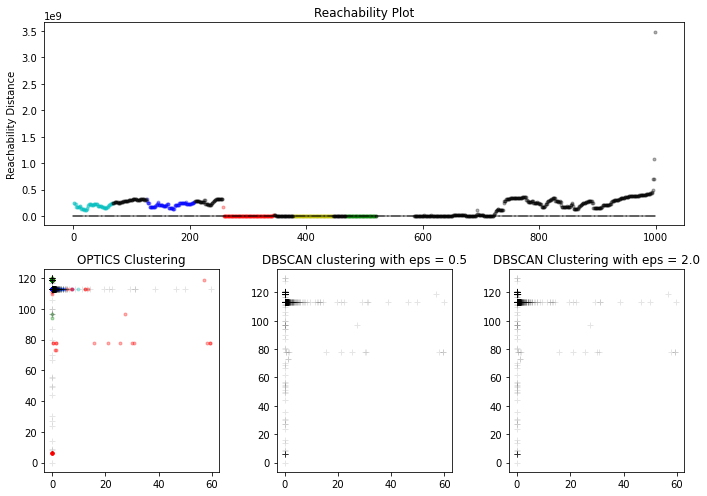

In [ ]:
# Defining the framework of the visualization 
plt.figure(figsize =(10, 7)) 
G = gridspec.GridSpec(2, 3) 
ax1 = plt.subplot(G[0, :]) 
ax2 = plt.subplot(G[1, 0]) 
ax3 = plt.subplot(G[1, 1]) 
ax4 = plt.subplot(G[1, 2]) 

# Plotting the Reachability-Distance Plot 
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
	Xk = space[labels == Class] 
	Rk = reachability[labels == Class] 
	ax1.plot(Xk, Rk, colour, alpha = 0.3) 
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha = 0.3) 
ax1.plot(space, np.full_like(space, 2., dtype = float), 'k-', alpha = 0.5) 
ax1.plot(space, np.full_like(space, 0.5, dtype = float), 'k-.', alpha = 0.5) 
ax1.set_ylabel('Reachability Distance') 
ax1.set_title('Reachability Plot') 

# Plotting the OPTICS Clustering 
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
	Xk = X_train[optics_model.labels_ == Class] 
	ax2.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3) 
	
ax2.plot(X_train.iloc[optics_model.labels_ == -1, 0], 
		X_train.iloc[optics_model.labels_ == -1, 1], 
	'k+', alpha = 0.1) 
ax2.set_title('OPTICS Clustering') 

# Plotting the DBSCAN Clustering with eps = 0.5 
colors = ['c', 'b', 'r', 'y', 'g', 'greenyellow'] 
for Class, colour in zip(range(0, 6), colors): 
	Xk = X_train[labels1 == Class] 
	ax3.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3, marker ='.') 
		
ax3.plot(X_train.iloc[labels1 == -1, 0], 
		X_train.iloc[labels1 == -1, 1], 
	'k+', alpha = 0.1) 
ax3.set_title('DBSCAN clustering with eps = 0.5') 

# Plotting the DBSCAN Clustering with eps = 2.0 
colors = ['c.', 'y.', 'm.', 'g.'] 
for Class, colour in zip(range(0, 4), colors): 
	Xk = X_train.iloc[labels2 == Class] 
	ax4.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3) 
		
ax4.plot(X_train.iloc[labels2 == -1, 0], 
		X_train.iloc[labels2 == -1, 1], 
	'k+', alpha = 0.1) 
ax4.set_title('DBSCAN Clustering with eps = 2.0') 


plt.tight_layout() 
plt.show() 
